## Welcome to the `Efficient Self-Attention Intuition` Workshop!
In this workshop, we'll try to visually understand following concepts:
- Overlap Patch Embedding / Merging
- Efficient Self Attention

### Library imports

In [ ]:
# !pip install -q einops
#!pip install -q ipympl
#!pip install -q segmentation-models-pytorch
# !pip install ipympl
# get_ipython().kernel.do_shutdown(restart=True)

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
# from google.colab import output
# output.enable_custom_widget_manager()

In [2]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/attention_concept_data.pickle

--2025-11-11 13:15:09--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/attention_concept_data.pickle
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 3.5.205.177, 3.5.205.38
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|3.5.205.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92013117 (88M) [application/x-www-form-urlencoded]
Saving to: ‘attention_concept_data.pickle’

attention_concept_d 100%[===================>]  87.75M  23.1MB/s    in 3.9s    

2025-11-11 13:15:13 (22.8 MB/s) - ‘attention_concept_data.pickle’ saved [92013117/92013117]



### Read input data

In [3]:
with open('attention_concept_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())

dict_keys(['key', 'query', 'value', 'attn', 'rgb_img', 'tf_img', 'patch_embed_output'])


In [4]:
print(data['rgb_img'].shape)

(512, 1024, 3)


### Plot the Image

In [5]:
def plot_single_channel_image(inputData, figsize, figTitle, save_plot = False, cmap=None,
                            plot_colorbar = False):
    fig = plt.figure(figsize=figsize)
    im = plt.imshow(inputData, cmap = cmap)
    plt.suptitle(figTitle);
    plt.axis('off');

    if(plot_colorbar):
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)

    if(save_plot):
        plt.savefig(f"{figTitle}.png")

### Show the Input Image

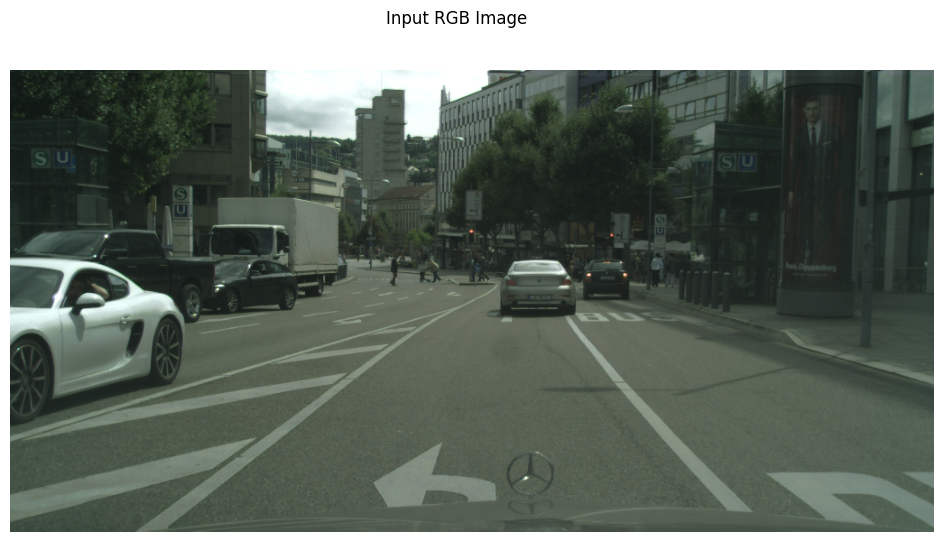

In [6]:
plot_single_channel_image(data['rgb_img'], (12,6), 'Input RGB Image')

## Overlap patch Embedding / Merging
- Entire image is split into patches which are passed to consequent Transformer blocks
- This layer acts like Embedding layer using Convolution layers
- Initial stage outputs indicate low-level features like edge detection and more abstract features in later stages

In [7]:
def plot_channels(inputData, num_rows, num_cols, figsize, figTitle, save_plot = False, cmap=None,
                  plot_colorbar = False):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i in range(len(axes)):
        im = axes[i].imshow(inputData[i], cmap=cmap)
        axes[i].axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(figTitle);

    if(plot_colorbar):
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)

    if(save_plot):
        fig.savefig(f"{figTitle}.png")

In [11]:
data['patch_embed_output'].shape

(1, 32768, 64)

patch_embed_output.shape = (32768, 64)
patch_embed_img.shape = (64, 128, 256)


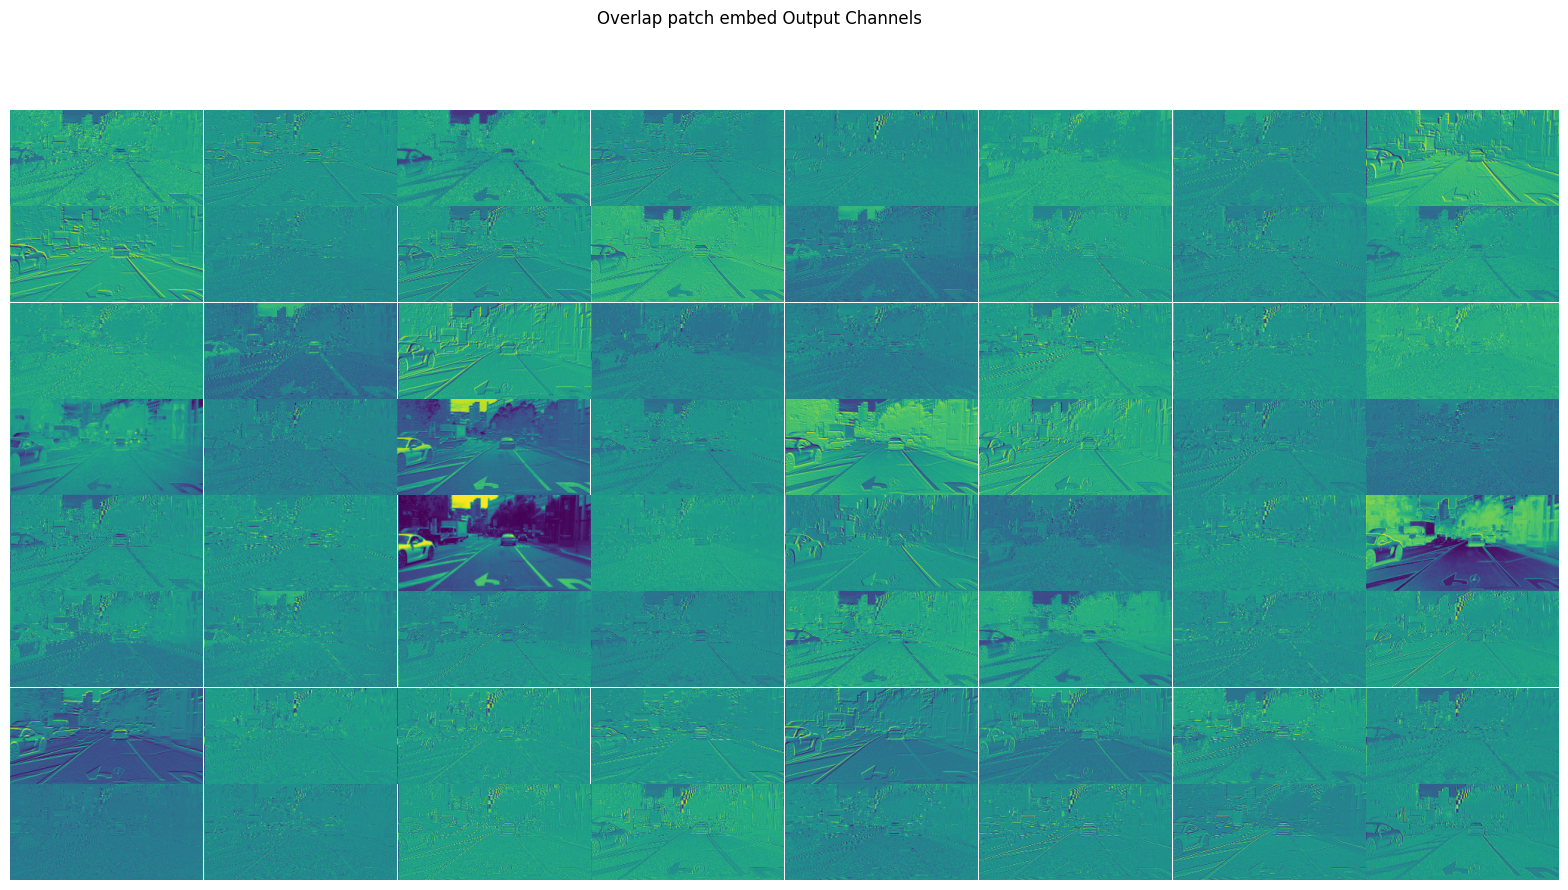

In [12]:
# read patch embedding layer output
patch_embed_output = data['patch_embed_output'][0]
print(f"patch_embed_output.shape = {patch_embed_output.shape}")

patch_embed_img = rearrange(patch_embed_output, '(h w) c -> c h w', h=128, w=256)
print(f"patch_embed_img.shape = {patch_embed_img.shape}")

# plot each channel of patch embedding
plot_channels(patch_embed_img, 8, 8, (20,10), 'Overlap patch embed Output Channels')

## Attention mechanism
- Attention mechanism involves 3 components - **Query, Key and Value**
- It is a mapping of a query and a set of key-value pairs to an output,
- Output is computed as a weighted sum of the values, where the weight assigned to each value is computed by similarity b/w query and corresponding key

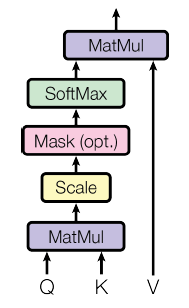

[Image reference](https://arxiv.org/abs/1706.03762)

**NOTE**
- Keys refer to input space (eg : embedded version of image coordinates)
- Query refers to output space (eg : Euclidean space in metres)
- Value can be any property in output space (eg: Depth, Speed of object at that location etc)

In [13]:
print(data.keys())

dict_keys(['key', 'query', 'value', 'attn', 'rgb_img', 'tf_img', 'patch_embed_output'])


## Query Visualization
- Query tries to match with certain features of specific type

In [20]:
print("Query shape:", data['query'].shape)
print("Key shape:  ", data['key'].shape)
print("Value shape:", data['value'].shape)

Query shape: (1, 1, 32768, 64)
Key shape:   (1, 1, 512, 64)
Value shape: (1, 1, 512, 64)


query_img.shape = (64, 128, 256)


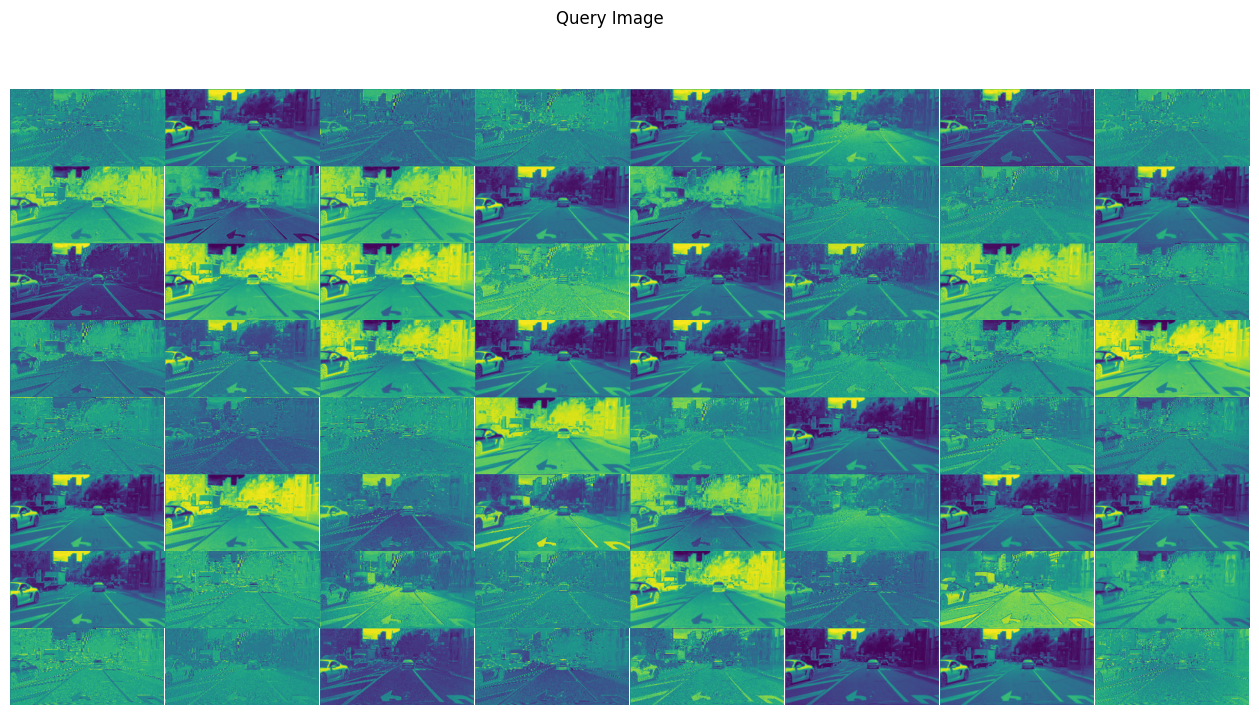

In [21]:
# query for first stage first block of transformer
query = data['query'][0][0]
query_img = rearrange(query, '(h w) c -> c h w', h=128, w=256)
print(f"query_img.shape = {query_img.shape}")

# plot each channel of Query
plot_channels(query_img, 8, 8, (16,8), 'Query Image')

## Key Visualization
- Key vector encodes that it's part of some object at some pixel location in input space and looking for features of specific type
- In Efficient self-attention, Key vector is << Query and hence appears pixelated

key_img.shape = (64, 16, 32)


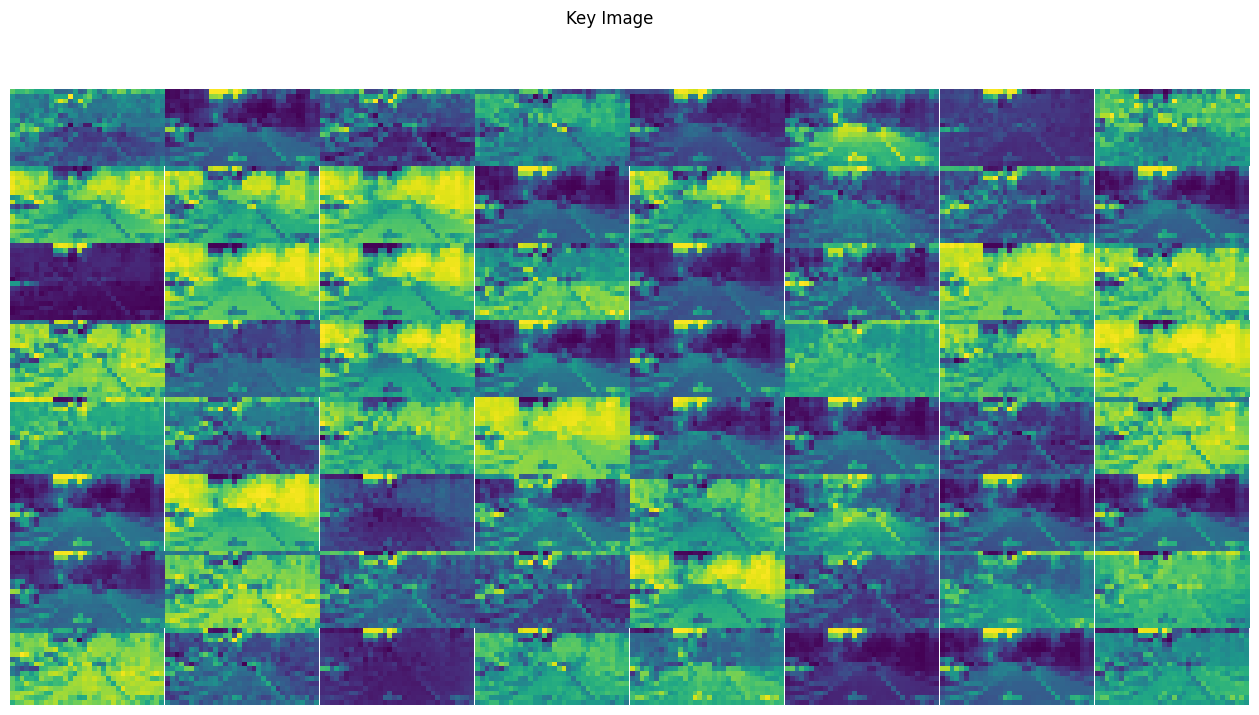

In [22]:
# key for first stage first block of transformer
key = data['key'][0][0]
key_img = rearrange(key, '(h w) c -> c h w', h=16, w=32)
print(f"key_img.shape = {key_img.shape}")

# plot each channel of Key of Transformer
plot_channels(key_img, 8, 8, (16,8), 'Key Image')

## Attention mechanism

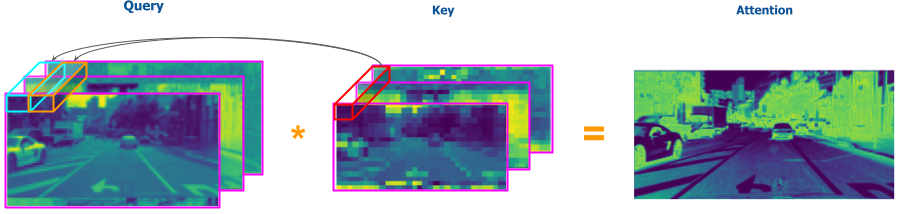

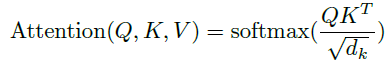

- Dot product is computed b/w each pixel combination in Query and Key matrices
- Output is scaled by key dimension and then softmax is applied
- Here, First pixel in Key contains **dark colored pixel** and we're comparing this feature with all pixels in Query Matrix
- **Pixels where query is similar to key (dark colored pixel) are given more weight in Attention output**


## Attention Visualization

attention_img.shape = (128, 256)


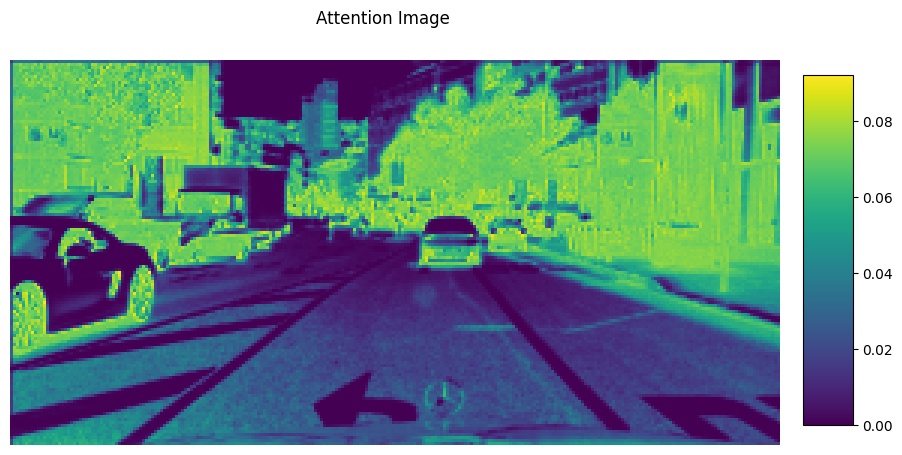

In [23]:
# Attention of 1st pixel in key w.r.t all Query pixels
attention = data['attn'][0, :, :, 0]
attention_img = attention.reshape(128,256)
print(f"attention_img.shape = {attention_img.shape}")
plot_single_channel_image(attention_img, (10,5), 'Attention Image', save_plot=True, plot_colorbar=True)

## ROI selection
Let's define a helper function to interactively select bounding boxes on an image and visualize the key.

In [24]:
import cv2
from ipywidgets import widgets
import IPython.display as Disp

class roi_select():
    def __init__(self,im, figsize=(12,6), line_color=(255,0,0)):
        # class variables
        self.im = im
        self.selected_points = []
        self.line_color = line_color

        # plot input image, store figure handles
        self.fig,ax = plt.subplots(figsize=figsize)
        self.img = ax.imshow(self.im.copy())
        plt.suptitle('Select Rectangular ROI')

        # connect event handlers
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)

    def draw_roi_on_img(self,img,pts):
        # plot polygon edges in single color
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,2))
        # cv2.polylines(img, [pts], True, self.line_color, 5)
        cv2.rectangle(img, pts[0], pts[1], self.line_color, 5)
        return img

    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points) == 2:
            self.img.set_data(self.draw_roi_on_img(self.im.copy(),self.selected_points))
            self.disconnect_mpl(None)

    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)


    def get_bbox_indices(self, scale_factor = None):
        pts = np.array(self.selected_points)
        if(scale_factor is not None):
            pts = pts * scale_factor

        # bounding box coordinates as indices
        # min_x, min_y is top left index
        # max_x, max_y is bottom right index
        roi_indices = pts.astype(int)
        indices = {}
        indices['min_x'], indices['min_y'] = np.min(roi_indices, axis=0)
        indices['max_x'], indices['max_y'] = np.max(roi_indices, axis=0)
        return indices


Before you get crazy with the bounding boxes below, click ONCE on the top left corner you want to pick, then wait 2/3 seconds, and click ONCE on the bottom right corner. Wait for the bounding box to be visible.

Button(description='Disconnect mpl', style=ButtonStyle())

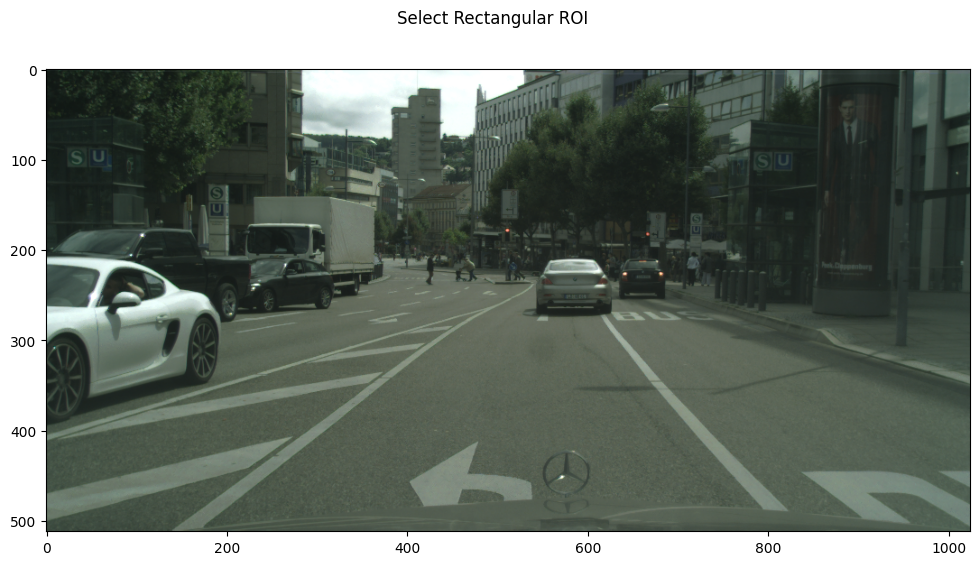

In [31]:
# %matplotlib ipympl
bs = roi_select(data['rgb_img'])

In [29]:
# convert bounding box coordinates to indices
roi_indices = bs.get_bbox_indices(scale_factor=(1.0/32))

# select attention for selected ROI
roi_attn = data['attn'][0][0]
roi_attn = rearrange(roi_attn, '(qh qw) (kh kw) -> kh kw (qh qw)', qh=128, qw=256, kh=16, kw=32)
roi_attn = roi_attn[roi_indices['min_y'] : roi_indices['max_y'], roi_indices['min_x'] : roi_indices['max_x'], :]

# rearrange dimensions to make channels first dimension
roi_attn_img = rearrange(roi_attn, 'h w (qh qw) -> (h w) qh qw ', qh=128, qw=256)
print(roi_attn_img.shape)

ValueError: zero-size array to reduction operation minimum which has no identity

IndexError: index 2 is out of bounds for axis 0 with size 2

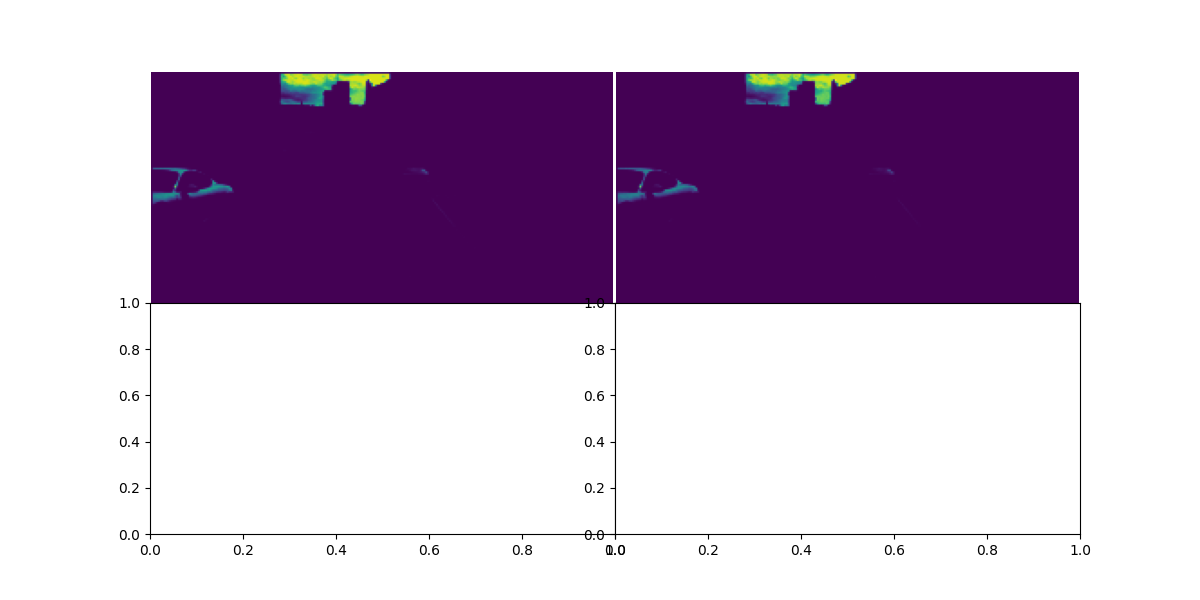

In [ ]:
plot_channels(roi_attn_img, 2, 2, (12,6), 'roi_attn Image', plot_colorbar=True)

Errors may be due to the dimensions/number of attention maps available, but you shpuld be able to visualize maps anyway!